<a name='1-1'></a>
## 1.1 Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import cv2
import os
import tensorflow as tf
import keras as keras
from keras import utils
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

sns.set()
%matplotlib inline

In [2]:
data_dir= './bone-classification'

In [3]:
train_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256, 256),
    batch_size=64,
    seed=40,
)

Found 1129 files belonging to 10 classes.
Using 1017 files for training.


In [4]:
vald_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256, 256),
    batch_size=64,
    seed=40,
)

Found 1129 files belonging to 10 classes.
Using 112 files for validation.


<a name='1-3'></a>

## 1.2 Create the Dataset and Split it into Training and Validation Sets

<a name='2-1'></a>
## 2.1 Check Labels of Images

In [5]:
print(train_data)
train_data.class_names

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


['Avulsion fracture',
 'Comminuted fracture',
 'Fracture Dislocation',
 'Greenstick fracture',
 'Hairline Fracture',
 'Impacted fracture',
 'Longitudinal fracture',
 'Oblique fracture',
 'Pathological fracture',
 'Spiral Fracture']

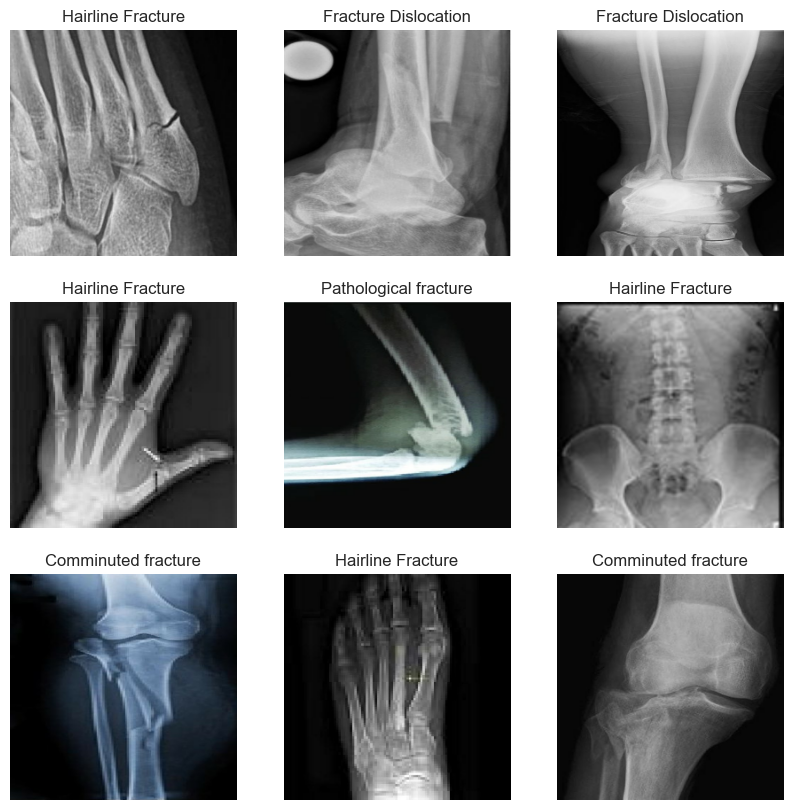

In [6]:
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
def normalize(image, label):
    return image/255.0, label

# normalize train and validation data for classification
train_data = train_data.map(normalize)
vald_data = vald_data.map(normalize)

for img, label in train_data.take(1):
    print(type(img), type(label))
    print(img.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 256, 256, 3)


## 3.x label training data

In [8]:
train_x = []
train_y = []

for image, label in train_data:
    train_x.append(image)
    train_y.append(label)
   
train_x = tf.concat(train_x, axis=0)
train_y = tf.concat(train_y, axis=0)

In [9]:
print(train_y)
print(train_x.shape)

tf.Tensor([9 2 5 ... 8 3 2], shape=(1017,), dtype=int32)
(1017, 256, 256, 3)


In [10]:
val_x = []
val_y = []
for image, label in train_data:
    val_x.append(image)
    val_y.append(label)
val_x = tf.concat(val_x, axis=0)
val_y = tf.concat(val_y, axis=0)

# one hot encoding
num_classes = 10
train_y = tf.keras.utils.to_categorical(train_y, num_classes=num_classes)
val_y = tf.keras.utils.to_categorical(val_y, num_classes=num_classes)

<a name='3-1'></a>
## 3.1 Building Final Edition Model

In [14]:
# Create a CNN
model = Sequential()
model.add(Input(shape=(256, 256, 3)))
model.add(Conv2D(60, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(120, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 254, 254, 60)        │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 127, 127, 60)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 125, 125, 120)       │          64,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 62, 120)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 461280)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 40)                  │      18,451,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             410 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,518,250 (70.64 MB)

 Trainable params: 18,518,250 (70.64 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
history = model.fit(train_x, train_y, batch_size=10, epochs=10,
          validation_data=(val_x, val_y))

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 56s 549ms/step - accuracy: 0.9011 - loss: 0.4500 - val_accuracy: 0.9725 - val_loss: 0.2242
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 57s 556ms/step - accuracy: 0.9742 - loss: 0.1541 - val_accuracy: 0.9892 - val_loss: 0.1316
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 57s 555ms/step - accuracy: 0.9867 - loss: 0.1865 - val_accuracy: 0.9892 - val_loss: 0.1227
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 57s 555ms/step - accuracy: 0.9876 - loss: 0.1430 - val_accuracy: 0.9941 - val_loss: 0.0472
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 57s 554ms/step - accuracy: 0.9874 - loss: 0.0779 - val_accuracy: 0.9931 - val_loss: 0.0785
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 56s 553ms/step - accuracy: 0.9954 - loss: 0.0513 - val_accuracy: 0.9951 - val_loss: 0.0736
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 54s 534ms/step - accuracy: 0.9893 - loss: 0.0798 - val_accuracy: 0.9931 - val_loss: 0.0446
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 55s 535ms/step - accuracy: 0.9960 - loss: 0

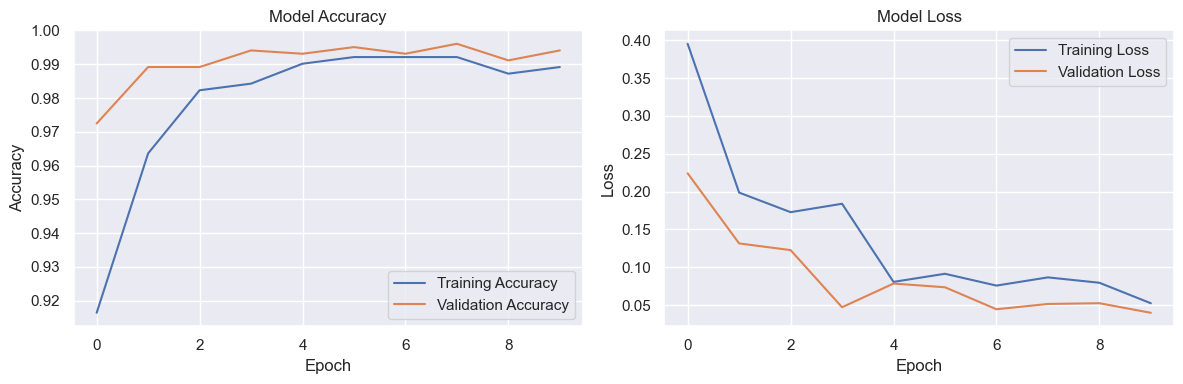

In [18]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

<a name='3-2'></a>
## 3.2 Train Model on our Data

<a name='4'></a>
# 4 - Evaluation Model

Test accuracy: 0.9941
Test loss: 0.0399
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step

Classification Report:
                       precision    recall  f1-score   support

    Avulsion fracture       1.00      0.99      1.00       109
  Comminuted fracture       1.00      0.98      0.99       127
 Fracture Dislocation       0.99      1.00      1.00       146
  Greenstick fracture       0.99      1.00      1.00       112
    Hairline Fracture       1.00      1.00      1.00       102
    Impacted fracture       0.97      0.99      0.98        76
Longitudinal fracture       0.99      1.00      0.99        76
     Oblique fracture       1.00      1.00      1.00        75
Pathological fracture       1.00      1.00      1.00       115
      Spiral Fracture       0.99      0.97      0.98        79

             accuracy                           0.99      1017
            macro avg       0.99      0.99      0.99      1017
         weighted avg       0.99      0.99      0.99      1017



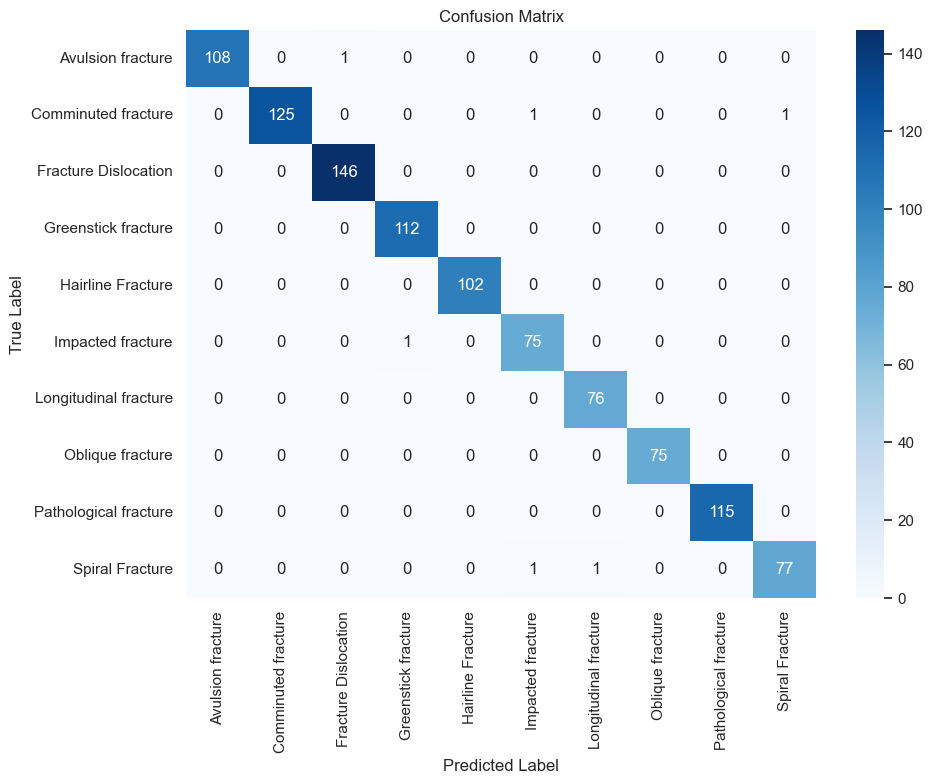

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_accuracy = model.evaluate(val_x, val_y, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

y_pred = model.predict(val_x)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(val_y, axis=1)

class_names = ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation',
               'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture',
               'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture',
               'Spiral Fracture']

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# 4. Create and plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [24]:
model.save('v1_bone_fracture_model.keras')